Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to apply simple data curation practices, and familiarize myself with the data.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [93]:
# Importing the required libraries that will be needed in the course of this assignment
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image, HTML
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from sklearn import metrics

First, we download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on this machine.

In [94]:
# URL to obtain the data from
url = 'http://commondatastorage.googleapis.com/books1000/'

# Function to download the data if not already downloaded
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  # Making sure that the data is the one that we expect
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

# Downloading the training and testing data
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give us a set of directories, labelled A through J.

In [95]:
# Defining class variables
num_classes = 10
np.random.seed(133)

# Function to extract the tar files if not already extracted
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
  # We may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  # Dividing the data into appropiate number of classes
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

# Obtaining the data paths for training and testing
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [96]:
# We first look at the number of files in each of the training classes
# Function to run through all the directories
def count_nfiles(dirpaths):
  for dirp in dirpaths:
    print(dirp, ": ", len(os.listdir(dirp)))
  return None

# Making sure that the images are uniformly distributed across all classes
print("train")
count_nfiles(train_folders)
print("test")
count_nfiles(test_folders)

train
notMNIST_large/A :  52912
notMNIST_large/B :  52912
notMNIST_large/C :  52912
notMNIST_large/D :  52912
notMNIST_large/E :  52912
notMNIST_large/F :  52912
notMNIST_large/G :  52912
notMNIST_large/H :  52912
notMNIST_large/I :  52912
notMNIST_large/J :  52911
test
notMNIST_small/A :  1873
notMNIST_small/B :  1873
notMNIST_small/C :  1873
notMNIST_small/D :  1873
notMNIST_small/E :  1873
notMNIST_small/F :  1873
notMNIST_small/G :  1872
notMNIST_small/H :  1872
notMNIST_small/I :  1872
notMNIST_small/J :  1872


We find that the training sets have ~52912 images in each while test set has ~1872 images in each.
Now we go into each folder of training set and plot some sample images from them

In [97]:
# Displaying 10 random sample images for each class
import random

# Function to plot a list of images in a row
def Images(images, width="100%"): # to match Image syntax
  if type(width)==type(1): width = "{}px".format(width)
  html = ["<table style='width:{}'><tr>".format(width)]
  # Displaying the images in a row
  for image in images:
    html.append("<td><img src='{}' /></td>".format(image))
  html.append("</tr></table>")
  display(HTML(''.join(html)))
  return None

# Function to plot the images using a dataset
def plot_samples(dirpaths):
  for dirp in dirpaths:
    print(dirp.split("/")[-1])
    f_list = os.listdir(dirp)
    sample_ids = random.sample(f_list, 10)
    sample_ids = [os.path.join(dirp, i) for i in sample_ids]
    Images(sample_ids, width="100%")
  return None

print("Train")
plot_samples(train_folders)
print("------------------")
print("Test")
plot_samples(train_folders)

Train
A


,,,,,,,,,


B


,,,,,,,,,


C


,,,,,,,,,


D


,,,,,,,,,


E


,,,,,,,,,


F


,,,,,,,,,


G


,,,,,,,,,


H


,,,,,,,,,


I


,,,,,,,,,


J


,,,,,,,,,


------------------
Test
A


,,,,,,,,,


B


,,,,,,,,,


C


,,,,,,,,,


D


,,,,,,,,,


E


,,,,,,,,,


F


,,,,,,,,,


G


,,,,,,,,,


H


,,,,,,,,,


I


,,,,,,,,,


J


,,,,,,,,,


Now We load the data in a more manageable format. We'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [98]:
# setting up the constants
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

# Function to load the data for each category
def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  image_index = 0
  print(folder)
  # Normalizing every image to mean 0 and standard deviation ~0.5
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
  # Including the relavant images in dataset  
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

# Function to distribute the data over classes
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # We may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray.

---

In [99]:
# First lets look at all the dataset list created
print(train_datasets)
print(test_datasets)

['notMNIST_large/A.pickle', 'notMNIST_large/B.pickle', 'notMNIST_large/C.pickle', 'notMNIST_large/D.pickle', 'notMNIST_large/E.pickle', 'notMNIST_large/F.pickle', 'notMNIST_large/G.pickle', 'notMNIST_large/H.pickle', 'notMNIST_large/I.pickle', 'notMNIST_large/J.pickle']
['notMNIST_small/A.pickle', 'notMNIST_small/B.pickle', 'notMNIST_small/C.pickle', 'notMNIST_small/D.pickle', 'notMNIST_small/E.pickle', 'notMNIST_small/F.pickle', 'notMNIST_small/G.pickle', 'notMNIST_small/H.pickle', 'notMNIST_small/I.pickle', 'notMNIST_small/J.pickle']


A


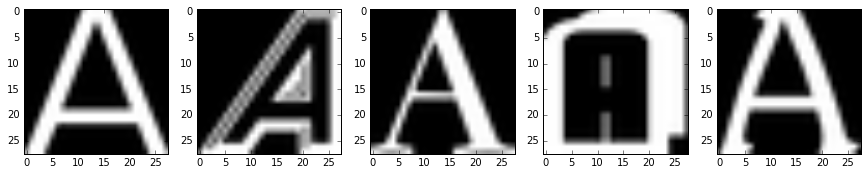

B


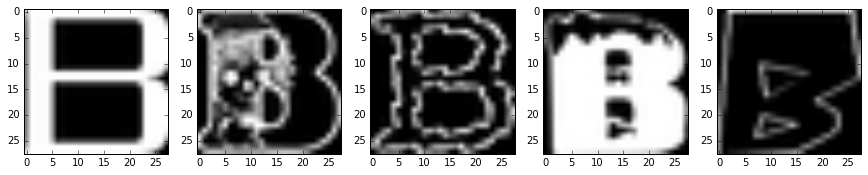

C


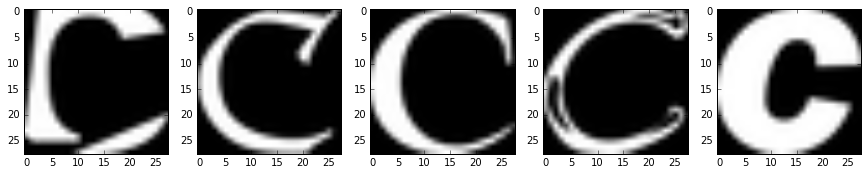

D


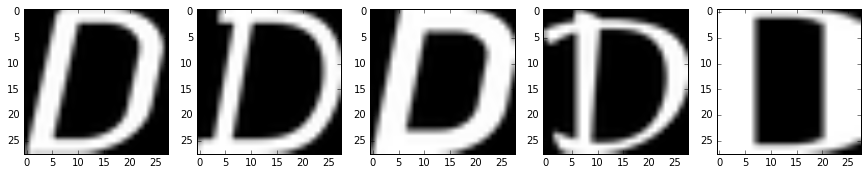

E


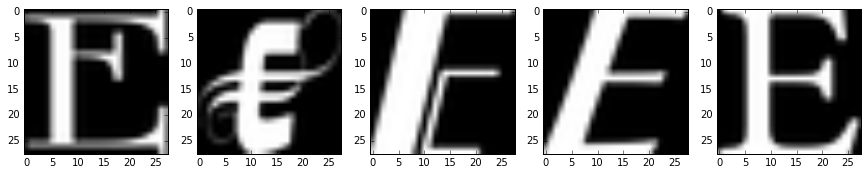

F


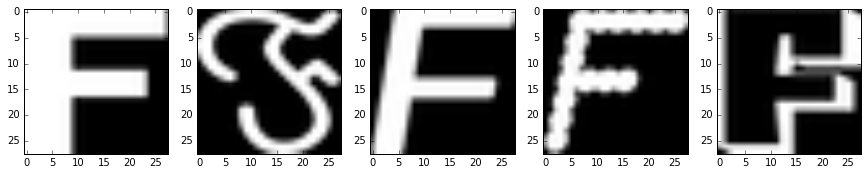

G


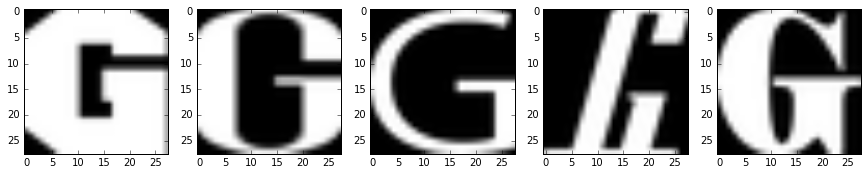

H


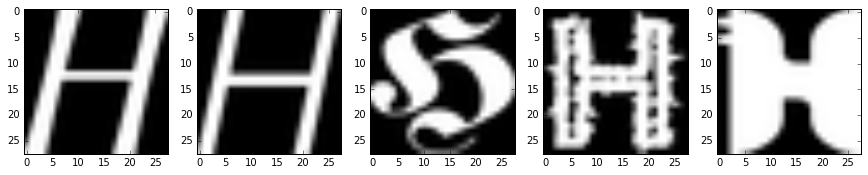

I


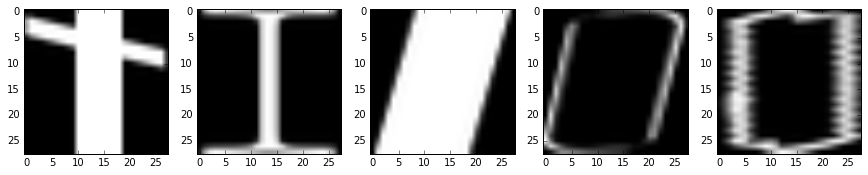

J


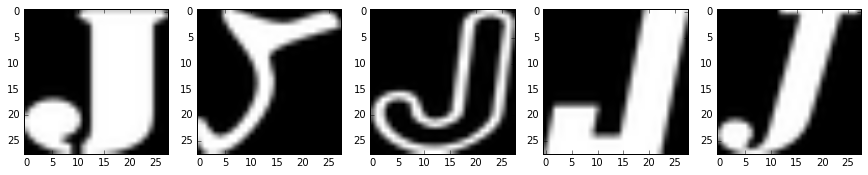

In [100]:
# Function to plot 3 random images from pickeled dataset
from matplotlib import pylab
def verify_dataset(dirspath):
  for pick in dirspath:
    print(pick.split("/")[-1].split(".")[0])
    df = open(pick, 'rb')
    dataset = pickle.load(df)
    # Selecting 3 random images
    sample_ids = random.sample(range(dataset.shape[0]), 5)
    # Display the images
    pylab.rcParams['figure.figsize'] = (15.0, 5.0)
    f, ax = plt.subplots(1, len(sample_ids))
    for i in range(len(sample_ids)):
      ax[i].imshow(dataset[sample_ids[i], :, :], cmap=plt.cm.gray)
    plt.show()
    df.close()
  return None

# Display the scaled dataset
verify_dataset(train_datasets)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

To check if the data is balanced across all the classes, we need to check if the number of images in our dataset are almost same across all the classes for both training and test case. Since we have 10 classes so every class should have about 8-12% of the total number of images across all classes

In [101]:
# Function to verify balancing of the data
def verify_balance(dataset_paths):
  # dictionary to hold the number of datapoints for each class
  dpoints = dict()
  for ds in dataset_paths:
    ds_tmp = open(ds, 'rb')
    ds_load = pickle.load(ds_tmp)
    dpoints[ds.split(".")[0][-1]] = ds_load.shape[0]
    ds_tmp.close()
  
  total_img = sum(dpoints.values())
  
  img_fraction = dict()
  for cl in dpoints:
    img_fraction[cl] = dpoints[cl]/float(total_img)
  # Checking if the img fraction lies between the desired range
  boo = [0.09 < i < 0.11 for i in img_fraction.values()]
  return all(boo)
    
print(verify_balance(train_datasets))

True


We find that the data is fairly balanced and uniformly distributed across all the classes

Next we merge and prune the training data for appropriate `train_size` as needed. The pruning is needed because of the limitations of the memory of the computer. The labels will be stored into a separate array of integers 0 through 9.

We also create a validation dataset for hyperparameter tuning.

In [102]:
# Function to initialize dataset and label arrays
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

# Function to merge all the classes to create a single dataset for training
def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        # Building the validation set
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
        # Building the training set
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
# Defining the number of datapoints for each set            
train_size = 100000
valid_size = 10000
test_size = 10000

# Splitting the training set into training and validation set
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (100000, 28, 28) (100000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [103]:
# Function to randomize a given dataset and labels pair
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Train data


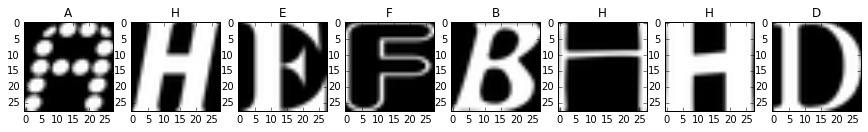

--------------
Test data


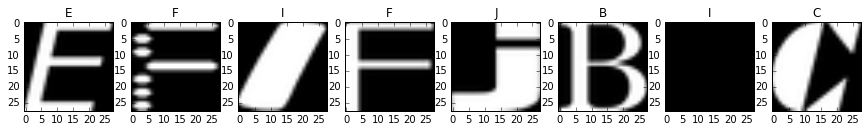

--------------
Validation data


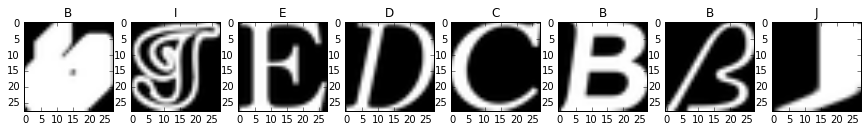

In [104]:
# To check the data after shuffling, we write a function that plots first 8 datapoints
def verify_shuffle(vs_dataset, vs_label):
  # A dictionary to convert labels to letters
  label_let = ["A", "B", "C", "D", "E",
              "F", "G", "H", "I", "J"]
  pylab.rcParams['figure.figsize'] = (15.0, 5.0)
  f, ax = plt.subplots(1, 8)
  for i in range(8):
    ax[i].imshow(vs_dataset[i, :, :], cmap=plt.cm.gray)
    ax[i].set_title(label_let[int(vs_label[i])])
  plt.show()
  return None

# Verify train data
print("Train data")
verify_shuffle(train_dataset, train_labels)
print("--------------")
print("Test data")
verify_shuffle(test_dataset, test_labels)
print("--------------")
print("Validation data")
verify_shuffle(valid_dataset, valid_labels)

We can see that the labels and the images match and the data is well shuffled

Finally, let's save the data for later reuse:

In [105]:
# We save the complete train, test and validation dataset as a single dictionary
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [106]:
pickle_file = 'notMNIST.pickle'
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size / float(1e6), " Mb")

Compressed pickle size: 376.800441  Mb


---
Problem 5
---------

By construction, the datasets created so far might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if we expect to use our model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
We need to measure how much overlap there is between training, validation and test samples.

We also need to take care of the following questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [107]:
# Now we look at the datasets to check for the overlaps

# Set the writeable flag to false for hashing
train_dataset.flags.writeable=False
test_dataset.flags.writeable=False
valid_dataset.flags.writeable=False
  
# Hashing the images for each dataset and saving it as a list to ensure that we save the indices
train_hashes = [hash(image.data) for image in train_dataset]
valid_hashes = [hash(image.data) for image in valid_dataset]
test_hashes = [hash(image.data) for image in test_dataset]

# Obtaining the unique hashes from the training hash
unique_train_hashes = set(train_hashes)
test_overlap_hashes = unique_train_hashes.intersection(set(test_hashes))
valid_overlap_hashes = unique_train_hashes.intersection(set(valid_hashes))

# Creating a dictionary with hash values as the keys and the indices of dataset with that hashvalues as its elements
train_hash_dict = {val: [] for val in unique_train_hashes}
test_hash_dict = {val: [] for val in test_overlap_hashes}
valid_hash_dict = {val: [] for val in valid_overlap_hashes}

# Populating the train_hash_dictionary
filter(lambda (i, val): train_hash_dict[val].append(i), enumerate(train_hashes))

# Test set only includes the hashes that are overlapping
for i, val in enumerate(test_hashes):
  if val in test_overlap_hashes:
    test_hash_dict[val].append(i)

# Same as test set
for i, val in enumerate(valid_hashes):
  if val in valid_overlap_hashes:
    valid_hash_dict[val].append(i)
    
# Summary of the results
print("Total number of train images: ", len(train_hashes))
print("Total number of unique train images: ", len(unique_train_hashes))
print("Total number of test images: ", len(test_hashes))
print("Total number of test overlaps with training hashes: ", sum([len(test_hash_dict[i]) for i in test_hash_dict]))
print("Total number of validation images: ", len(valid_hashes))
print("Total number of valid overlaps with training hashes: ", sum([len(valid_hash_dict[i]) for i in valid_hash_dict]))

Total number of train images:  100000
Total number of unique train images:  96052
Total number of test images:  10000
Total number of test overlaps with training hashes:  771
Total number of validation images:  10000
Total number of valid overlaps with training hashes:  673


#### For testing and validation set, overlapping images with training set is a problem but duplicate images within the testing and validation sets are probably fine.

### Sanitizing the dataset

We have a train_hash_dict with keys as hash values and list of images indices as values. We take the first element of each list to have a unique elememts

In [108]:
# Obtaining indices of unique train images
unique_train_indices = [train_hash_dict[keyword][0] for keyword in train_hash_dict]
print("Total unique images in train set: ", len(unique_train_indices))

# List of overlapping traintest indices
overlap_traintest_indices = []
for image_hash in test_hash_dict:
  overlap_traintest_indices += test_hash_dict[image_hash]
print("Total number of test overlap images: ", len(overlap_traintest_indices))

# List of overlapping trainvalid indices
overlap_trainvalid_indices = []
for image_hash in valid_hash_dict:
  overlap_trainvalid_indices += valid_hash_dict[image_hash]
print("Total number of valid overlap images: ", len(overlap_trainvalid_indices))

# Obtaining the nonoverlapping test indices
nonoverlap_test_indices = range(len(test_hashes))
for i in overlap_traintest_indices: nonoverlap_test_indices.remove(i)
print("Total number of test nonoverlap images: ", len(nonoverlap_test_indices))

# Obtaining the nonoverlapping valid indices
nonoverlap_valid_indices = range(len(valid_hashes))
for i in overlap_trainvalid_indices: nonoverlap_valid_indices.remove(i)
print("Total number of valid nonoverlap images: ", len(nonoverlap_valid_indices))

Total unique images in train set:  96052
Total number of test overlap images:  771
Total number of valid overlap images:  673
Total number of test nonoverlap images:  9229
Total number of valid nonoverlap images:  9327


In [109]:
# saving the sanitized data for future use
# Function to slice the dataset and labels appropriately and save it as a pickle
def save_sanitized_data(fulldataset, fulllabels, sanitized_indices, set_type):
  fname_d = "A1_sanitized_"+set_type+".pickle"
  if not os.path.exists(fname_d):
    sanit_dict = {'dataset': train_dataset[np.array(sanitized_indices)],
                 'labels': fulllabels[np.array(sanitized_indices)]}
    print(set_type)
    print("dataset shape: ", sanit_dict['dataset'].shape)
    print("labels shape: ", sanit_dict['labels'].shape)
    
    f2write = open(fname_d, "wb")
    pickle.dump(sanit_dict, f2write, pickle.HIGHEST_PROTOCOL)
    f2write.close()
  
  return None

save_sanitized_data(train_dataset, train_labels, unique_train_indices, "train")
save_sanitized_data(test_dataset, test_labels, nonoverlap_test_indices, "test")
save_sanitized_data(valid_dataset, valid_labels, nonoverlap_valid_indices, "valid")

train
dataset shape:  (96052, 28, 28)
labels shape:  (96052,)
test
dataset shape:  (9229, 28, 28)
labels shape:  (9229,)
valid
dataset shape:  (9327, 28, 28)
labels shape:  (9327,)


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

#### We train a logistic regression model on the training sets of sample sizes 50, 100, 1000 and 5000 and use the entire validation set to observe the changes in validation error as the training size grows

In [113]:
# Now we write a function that returns the optimized training parameters for a Logistic Regression modelgiven training set size.
# It used the train_dataset as the superset for data
# importing the desired modules

def logReg_train(n):

  # n is the sample size that training is to be done on
  # generate an array of indices for selecting the training subset
  train_id = np.random.choice(range(train_dataset.shape[0]), n)
  train_dataset_subset = train_dataset[train_id, :, :]
  # flatten the subset for training
  train_dataset_subset = train_dataset_subset.reshape(train_dataset_subset.shape[0], -1)
  train_labels_subset = train_labels[train_id]

  # Setting up a simple classifier with low regularization and training on the training subset
  # We use all the defaults for Logistic regression model
  logistic_classifier = LogisticRegression(C=100.0)
  logistic_classifier.fit(train_dataset_subset, train_labels_subset)
  
  print(train_dataset_subset.shape)
  print(train_labels_subset.shape)

  return logistic_classifier

# generating models with varying training sizes
logReg_50 = logReg_train(50)
logReg_100 = logReg_train(100)
logReg_1000 = logReg_train(1000)
logReg_5000 = logReg_train(5000)

(50, 784)
(50,)
(100, 784)
(100,)
(1000, 784)
(1000,)
(5000, 784)
(5000,)


In [111]:
# Now we predict the validation set data and observe the test errors as a function of training size
# Reshaping the validation dataset for the model
valid_dataset_flat = valid_dataset.reshape(valid_dataset.shape[0], -1)

# Function to return the precision and recall for a training model
def preRec(trained_model, validation_x, validation_y):
  # Report of prediction
  report = metrics.classification_report(validation_y, trained_model.predict(validation_x))
  # Extracting the relevant parameters from the report
  report_crux = report.split("\n")[-2]
  precision = float(report_crux.split()[-4])
  recall = float(report_crux.split()[-3])  
  
  return (precision, recall)

# Creating lists for plotting
train_size = [50, 100, 1000, 5000]
precision_list = []
recall_list = []

# Populating the precision and recall list
for model in [logReg_50, logReg_100, logReg_1000, logReg_5000]:
    prec, rec = preRec(model, valid_dataset_flat, valid_labels)
    precision_list.append(prec)
    recall_list.append(rec)

print(precision_list, recall_list)

[0.61, 0.67, 0.74, 0.72] [0.58, 0.66, 0.74, 0.72]


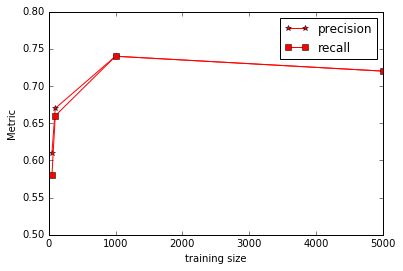

In [114]:
# Plotting the precision and recall
%matplotlib inline
plt.plot(train_size, precision_list, 'r*-', label = 'precision')
plt.plot(train_size, recall_list, 'rs-', label = 'recall')
plt.legend()
plt.xlabel("training size")
plt.ylabel("Metric")
plt.ylim(0.5, 0.8)
plt.show()